In [119]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from utils import *
import os
import joblib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

这里解释一下alpha的值。alpha几乎都是使用rank()函数来构造的，因此不是原始数据，而是相当于是一种标准化后的值，对原始的分布是肯定有更改的。如果要可视化原始数据的图，使用data_merged文件夹中的数据。

In [120]:
def mse1(y_true, y_pred):
    if(y_true is None or y_pred is None):
        return 0
    
    return np.mean((y_true - y_pred)**2)

## 一、读取因子数据

In [121]:
start_date = '2011-04-30'
end_date = '2018-04-30'

In [122]:
df_all = pd.read_csv('data/df_all.csv', dtype={'asset': str})
df_all['date'] = pd.to_datetime(df_all['date'])

# df_all = df_all[(df_all['date'] >= start_date) & (df_all['date'] <= end_date)]

df_all.drop(['Unnamed: 0', 'Rmrf', 'Smb', 'Hml'], axis=1, inplace=True)
df_all_pivot = df_all.pivot(index='date', columns='asset')

In [123]:
df_all_pivot.columns

MultiIndex([('open', '000001'),
            ('open', '000002'),
            ('open', '000009'),
            ('open', '000012'),
            ('open', '000021'),
            ('open', '000027'),
            ('open', '000031'),
            ('open', '000039'),
            ('open', '000046'),
            ('open', '000059'),
            ...
            (  'ep', '601898'),
            (  'ep', '601899'),
            (  'ep', '601918'),
            (  'ep', '601919'),
            (  'ep', '601939'),
            (  'ep', '601958'),
            (  'ep', '601988'),
            (  'ep', '601989'),
            (  'ep', '601991'),
            (  'ep', '601998')],
           names=[None, 'asset'], length=7776)

In [124]:
returns = pd.read_csv('data/returns.csv', index_col=0)
returns.index = pd.to_datetime(returns.index)
all_time_index = returns.index
all_time_index

DatetimeIndex(['2011-05-03', '2011-05-04', '2011-05-05', '2011-05-06',
               '2011-05-09', '2011-05-10', '2011-05-11', '2011-05-12',
               '2011-05-13', '2011-05-16',
               ...
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-24', '2023-04-25', '2023-04-26',
               '2023-04-27', '2023-04-28'],
              dtype='datetime64[ns]', name='date', length=2918, freq=None)

In [125]:
assets = returns.columns

In [126]:
# 从因子数据中读取因子
alphaset = 'ourAlphas'
subset = '20110430'

from MyBacktrader import get_alpha_list

alpha_names = get_alpha_list(f'alphas/{alphaset}/{subset}')
# alpha_names = ['alpha_financial_health']

for alpha_name in alpha_names:
    alpha = pd.read_csv('alphas/{}/{}/{}.csv'.format(alphaset, subset, alpha_name))
    
    # 从因子数据中读取因子
    alpha = alpha.set_index('date')
    alpha.index = pd.to_datetime(alpha.index)

    # 给 alpha 添加双重索引
    alpha.columns = pd.MultiIndex.from_product([[f'{alpha_name}'], alpha.columns], names=['', 'asset'])

    # 合并 alpha 到 df_all_pivot
    df_all_pivot = pd.concat([df_all_pivot, alpha], axis=1)


In [127]:
Y = returns - df_all_pivot['rf'].values
# print(Y.head())

# 截取时间段
Y = Y[(Y.index >= start_date) & (Y.index <= end_date)]

X = df_all_pivot.drop(['rf', 'alpha_Fama_French', 'open', 'close', 'high', 'low', 'volume', 'amount', 'pctChg', 'cta', 'roe','vwap', 'pctChg',
       'turnover', 'benchmark_open', 'benchmark_close', 'benchmark_high',
       'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd', 'epq', 'emq',
       'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm', 'alpha_CH3', 'ep'], axis=1, level=0)

X = X[(X.index >= start_date) & (X.index <= end_date)]

X.columns.get_level_values(0).unique()

Index(['alpha001', 'alpha_ALAQ', 'alpha_bm', 'alpha_CTA', 'alpha_CVD',
       'alpha_EMQ', 'alpha_EP', 'alpha_EPQ', 'alpha_financial_health',
       'alpha_High_Low', 'alpha_liquidity', 'alpha_market_alpha',
       'alpha_momentum', 'alpha_momentum_60', 'alpha_multi', 'alpha_PMQ',
       'alpha_PMQ_momentum', 'alpha_Price_VWAP', 'alpha_reversal',
       'alpha_Rmrf', 'alpha_ROA_momentum', 'alpha_ROE', 'alpha_ROE_ROA',
       'alpha_rsi', 'alpha_sentiment', 'alpha_SGQ', 'alpha_SGQ_volatility',
       'alpha_size', 'alpha_trade_density', 'alpha_turnover',
       'alpha_turnover_10', 'alpha_turnover_month', 'alpha_Volume_Close',
       'alpha_vol_skew'],
      dtype='object')

In [128]:
X.index

DatetimeIndex(['2011-05-03', '2011-05-04', '2011-05-05', '2011-05-06',
               '2011-05-09', '2011-05-10', '2011-05-11', '2011-05-12',
               '2011-05-13', '2011-05-16',
               ...
               '2018-04-16', '2018-04-17', '2018-04-18', '2018-04-19',
               '2018-04-20', '2018-04-23', '2018-04-24', '2018-04-25',
               '2018-04-26', '2018-04-27'],
              dtype='datetime64[ns]', name='date', length=1702, freq=None)

## 二、普通的线性回归

In [129]:
def linear_regression(y, X):
    model = LinearRegression()
    model.fit(X, y)
    return model

In [130]:
# 提取资产列表（多重索引的第二层）
assets = X.columns.get_level_values(1).unique()
# assets = ['601939']
dates = Y.index

# 创建 DataFrame 存储回归结果
# linear_betas = pd.DataFrame(columns=['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept'])
expected_columns = ['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept']

linear_models = {}

total_mse_linear = 0
linear_preds = pd.DataFrame(index=dates, columns=assets)

# 对每个资产进行回归
for asset in tqdm(assets):
    # print("asset: ", asset)
    # 提取该资产对应的 Y 和 X
    y = Y[asset].dropna()
    x = X.xs(asset, axis=1, level=1).reindex(y.index)  # 确保时间对齐

    # 添加常数项
    x = sm.add_constant(x)

    # 找出缺失的列
    missing_columns = [col for col in expected_columns if col not in x.columns and col != 'Asset']
    
    # 手动补充缺失列
    for col in missing_columns:
        x[col] = 0

    # 确保列顺序一致
    x = x[expected_columns[1:]]  # 排除 'Asset'，其余列按 expected_columns 的顺序排列

    # 回归分析
    model = sm.OLS(y, x).fit()
    
    pred = model.predict(x)
    linear_preds[asset] = pred

    # 计算 MSE
    mse_val = mse1(y, pred)
    total_mse_linear += mse_val

    # 记录回归结果
    result = [asset] + list(model.params.reindex(expected_columns[1:]).fillna(0).values)
    
    # 保存回归模型
    linear_models[asset] = model

100%|██████████| 288/288 [00:05<00:00, 54.91it/s]


## 三、逐步回归

注意，这里我尝试了一下使用稳健标准误（见下面的两行注释），预测结果反而变差了，如果更注重预测结果，把括号里的cov_type = 'HC3'去掉

In [131]:
def stepwise_regression(y, X, direction='both', threshold_in=0.05, threshold_out=0.10):
    """
    逐步回归方法，进行特征选择，返回最优模型以及选择的特征
    :param y: 目标变量（依赖变量）
    :param X: 特征变量（自变量）
    :param direction: 选择方法：'forward'、'backward' 或 'both'
    :param threshold_in: 进入模型的显著性水平
    :param threshold_out: 离开模型的显著性水平
    :return: 最优模型以及选择的特征
    """
    initial_vars = X.columns.tolist()
    best_aic = float('inf')
    best_model = None
    remaining_vars = initial_vars.copy()
    selected_vars = []

    while True:
        changed = False
        
        if direction in ['both', 'forward']:  # 前向选择
            # 遍历所有未进入模型的变量
            for var in remaining_vars:
                model = sm.OLS(y, sm.add_constant(X[selected_vars + [var]])).fit(cov_type='HC3')#使用稳健标准误
                aic = model.aic
                # 仅当 AIC 更低时才加入该变量
                if aic < best_aic:
                    best_aic = aic
                    best_model = model
                    best_var = var
                    changed = True
                    selected_vars.append(best_var)
                    remaining_vars.remove(best_var)
                    break  # 只选择一个变量后继续向前

        if direction in ['both', 'backward']:  # 后向剔除
            # 遍历所有已进入模型的变量
            for var in selected_vars:
                temp_selected_vars = selected_vars.copy()
                temp_selected_vars.remove(var)
                model = sm.OLS(y, sm.add_constant(X[temp_selected_vars])).fit(cov_type='HC3') #使用稳健标准误
                aic = model.aic
                # 仅当 AIC 更低时才剔除该变量
                if aic < best_aic:
                    best_aic = aic
                    best_model = model
                    best_var = var
                    changed = True
                    selected_vars.remove(best_var)
                    break  # 只剔除一个变量后继续向后

        if not changed:
            break  # 没有变化，退出循环

    return best_model, selected_vars  # 返回最优模型及选择的特征

In [137]:
import joblib

# 提取资产列表（多重索引的第二层）
assets = X.columns.get_level_values(1).unique()
# assets = ['601939']
dates = Y.index

# 创建 DataFrame 存储回归结果
# regression_betas = pd.DataFrame(columns=['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept'])
expected_columns = ['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept']

regression_models = {}
regression_preds = pd.DataFrame(index=dates, columns=assets)

total_mse_regression = 0

# 这里是因为我已经保存过模型了，所以直接读取模型。如果要跑的话把下面一整段的注释取掉一次即可

# 对每个资产进行回归
for asset in tqdm(assets):
    # print("asset: ", asset)
    # 提取该资产对应的 Y 和 X
    y = Y[asset].dropna()
    x = X.xs(asset, axis=1, level=1).reindex(y.index)  # 确保时间对齐

    # 添加常数项
    x = sm.add_constant(x)

    # 找出缺失的列
    missing_columns = [col for col in expected_columns if col not in x.columns and col != 'Asset']
    
    # 手动补充缺失列
    for col in missing_columns:
        x[col] = 0

    # 确保列顺序一致
    x = x[expected_columns[1:]]  # 排除 'Asset'，其余列按 expected_columns 的顺序排列
    
    # 对特征进行逐步回归
    stepwise_model, selected_vars = stepwise_regression(y, x)

    # print(selected_vars)
    # print(stepwise_model.summary())
    
    # 获取逐步回归后的预测值
    pred = stepwise_model.predict(sm.add_constant(x[selected_vars]))  # 用最终选择的特征进行预测
    regression_preds[asset] = pred

    # 计算 MSE
    mse_val = mse1(y, pred)
    total_mse_regression += mse_val

    # 记录回归结果
    result = [asset] + list(stepwise_model.params.reindex(expected_columns[1:]).fillna(0).values)
    
    # 保存回归模型
    regression_models[asset] = stepwise_model
    
    # 可以选择取消注释下面的代码来保存模型
    
    # # 如果路径不存在，创建路径
    # if not os.path.exists('models/regression_models'):
    #     os.makedirs('models/regression_models')
    
    # joblib.dump(stepwise_model, f'models/regression_models/{asset}.pkl')

print("MSE:")
print(total_mse_regression)

  0%|          | 0/288 [00:00<?, ?it/s]

100%|██████████| 288/288 [05:21<00:00,  1.12s/it]

MSE:
142.41520592409768


下面是画图函数

In [133]:
plt.rcParams['axes.unicode_minus'] = False
def plot_y_and_pred(y, pred, asset_id, ifshow=True):
    plt.figure(figsize=(10, 6))
    plt.scatter(y.index, y, label='True', s = 5)
    plt.scatter(pred.index, pred, label='Predicted', s = 5)
    plt.title(f'True and Predicted Returns of {asset_id}')
    plt.legend()
    
    if ifshow:
        plt.show()
        
    else:
        plt.savefig(f'output_charts/predicts/{asset_id}.png')
        plt.close()

In [134]:
# 提取该资产对应的 Y 和 pred
y1 = returns - df_all_pivot['rf'].values
index_all = y1.index
X1 = df_all_pivot.drop(['rf', 'alpha_Fama_French', 'open', 'close', 'high', 'low', 'volume', 'amount', 'pctChg', 'cta', 'roe','vwap', 'pctChg',
       'turnover', 'benchmark_open', 'benchmark_close', 'benchmark_high',
       'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd', 'epq', 'emq',
       'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm','alpha_CH3', 'ep'], axis=1, level=0)

def plot_test_pred(y, X, asset_id, ifshow=True, isXgb=False):
       y1 = y[asset_id].dropna()
       y1 = pd.Series(y1, index=index_all)

       model = regression_models[asset_id]
       selected_vars = model.params.index.tolist()
       
       isIntercept = False
       if('Intercept' in selected_vars):
              isIntercept = True
       isconst = False
       if('const' in selected_vars):
              isconst = True
       
       selected_vars = [var for var in selected_vars if var != 'const' and var != 'Intercept']
       
       # print(model.params)
       
       # print(model.params.shape)
       X2 = X.xs(asset_id, axis=1, level=1)[selected_vars]
       
       if 'const' not in X2.columns and isconst:
              X2 = sm.add_constant(X2)
       if isIntercept:
              X2['Intercept'] = 1
              
       # print(X2.columns)
       
       pred = model.predict(X2)
       
       pred = pd.Series(pred, index=index_all)
       
       print(X.shape, y1.shape, pred.shape)
       
       test_mse = mse1(y1, pred)
       print(f"Test MSE: {test_mse}")       
       
       plot_y_and_pred(y1, pred, asset_id, ifshow)


画图函数的使用

(2918, 9792) (2918,) (2918,)
Test MSE: 0.8732147183522241


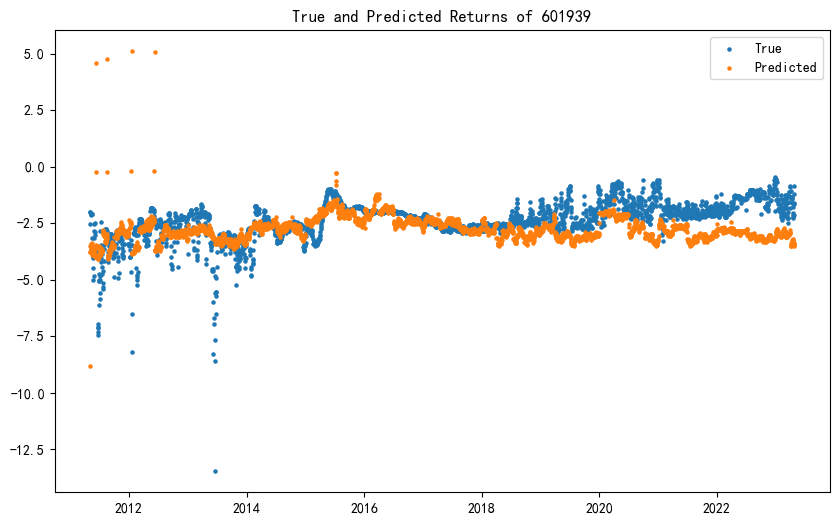

In [138]:
asset_id = '601939'

plot_test_pred(y1, X1, asset_id, isXgb=False)

## 四、模型检验

In [139]:
# 选取一个model

asset_id = '601939'

results = regression_models[asset_id]

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 601939   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     64.52
Date:                Tue, 03 Dec 2024   Prob (F-statistic):          1.02e-153
Time:                        18:27:31   Log-Likelihood:                -1827.9
No. Observations:                1693   AIC:                             3688.
Df Residuals:                    1677   BIC:                             3775.
Df Model:                          15                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
alpha_CVD               -0.5306 

残差正态性检验：可以通过残差的 Q-Q 图或 Shapiro-Wilk 检验来评估。

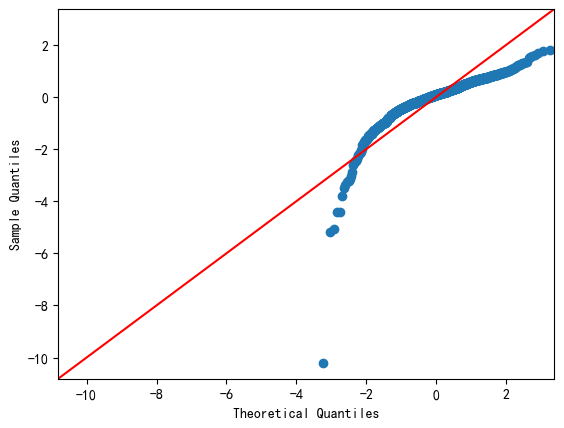

Shapiro-Wilk p-value: 1.2343866179401652e-40


In [140]:
import scipy.stats as stats

# Q-Q图
sm.qqplot(results.resid, line ='45')
plt.show()

# Shapiro-Wilk检验
stat, p_value = stats.shapiro(results.resid)
print(f'Shapiro-Wilk p-value: {p_value}')

异方差性检验（Breusch-Pagan检验）：用于检验模型是否存在异方差性。

In [141]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Breusch-Pagan 异方差性检验
bp_test = het_breuschpagan(results.resid, results.model.exog)
print(bp_test)  # 输出包括LM统计量和p值


(np.float64(83.6545955853106), np.float64(1.490119014590405e-11), np.float64(5.811421066467217), np.float64(7.375644112650533e-12))


自相关检验（Durbin-Watson检验）：用于检验残差是否存在自相关（尤其在时间序列数据中）。

In [143]:
# Durbin-Watson 检验
dw_stat = sm.stats.durbin_watson(results.resid)
print(f'Durbin-Watson statistic: {dw_stat}')

Durbin-Watson statistic: 0.26077934861335117


多重共线性检验：方差膨胀因子（VIF），VIF 值较高（如 > 10）表示存在严重共线性问题。

In [144]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 要提取单个股票的x和y时使用这段代码
y = Y[asset_id].dropna()
x = X.xs(asset_id, axis=1, level=1).reindex(y.index)

# 计算VIF
X_no_const = x.iloc[:, 1:]  # 去掉常数项
vif = [variance_inflation_factor(X_no_const.values, i) for i in range(X_no_const.shape[1])]
vif = pd.Series(vif, index=X_no_const.columns, name='VIF')
print(vif)

alpha_ALAQ                      NaN
alpha_bm                   0.000000
alpha_CTA                       NaN
alpha_CVD                  2.463825
alpha_EMQ                       NaN
alpha_EP                   0.000000
alpha_EPQ                  0.000000
alpha_financial_health          NaN
alpha_High_Low             3.730441
alpha_liquidity                 NaN
alpha_market_alpha         8.637747
alpha_momentum             2.257847
alpha_momentum_60          2.319067
alpha_multi                5.489439
alpha_PMQ                  2.159719
alpha_PMQ_momentum         1.605251
alpha_Price_VWAP           1.043028
alpha_reversal             7.928988
alpha_Rmrf                 1.980826
alpha_ROA_momentum         3.296538
alpha_ROE                  2.240117
alpha_ROE_ROA              2.030633
alpha_rsi                  2.082518
alpha_sentiment            2.388746
alpha_SGQ                  2.695510
alpha_SGQ_volatility       2.061914
alpha_size                 9.456457
alpha_trade_density        7

e:\Anaconda\envs\py310\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
e:\Anaconda\envs\py310\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


## 五、模型优化

可以只对一个股票进行模型优化，比如使用WLS,LASSO,Ridge

In [145]:
# 从模型中提取出逐步回归选择的变量作为接下来优化的基础，也可以不进行这一步，直接使用所有变量
# selected_vars_id = results.params.index.tolist()


y = Y[asset_id].dropna()
# x = X.xs(asset_id, axis=1, level=1).reindex(y.index)[selected_vars_id]
x = X.xs(asset_id, axis=1, level=1).reindex(y.index)

# print(selected_vars_id)

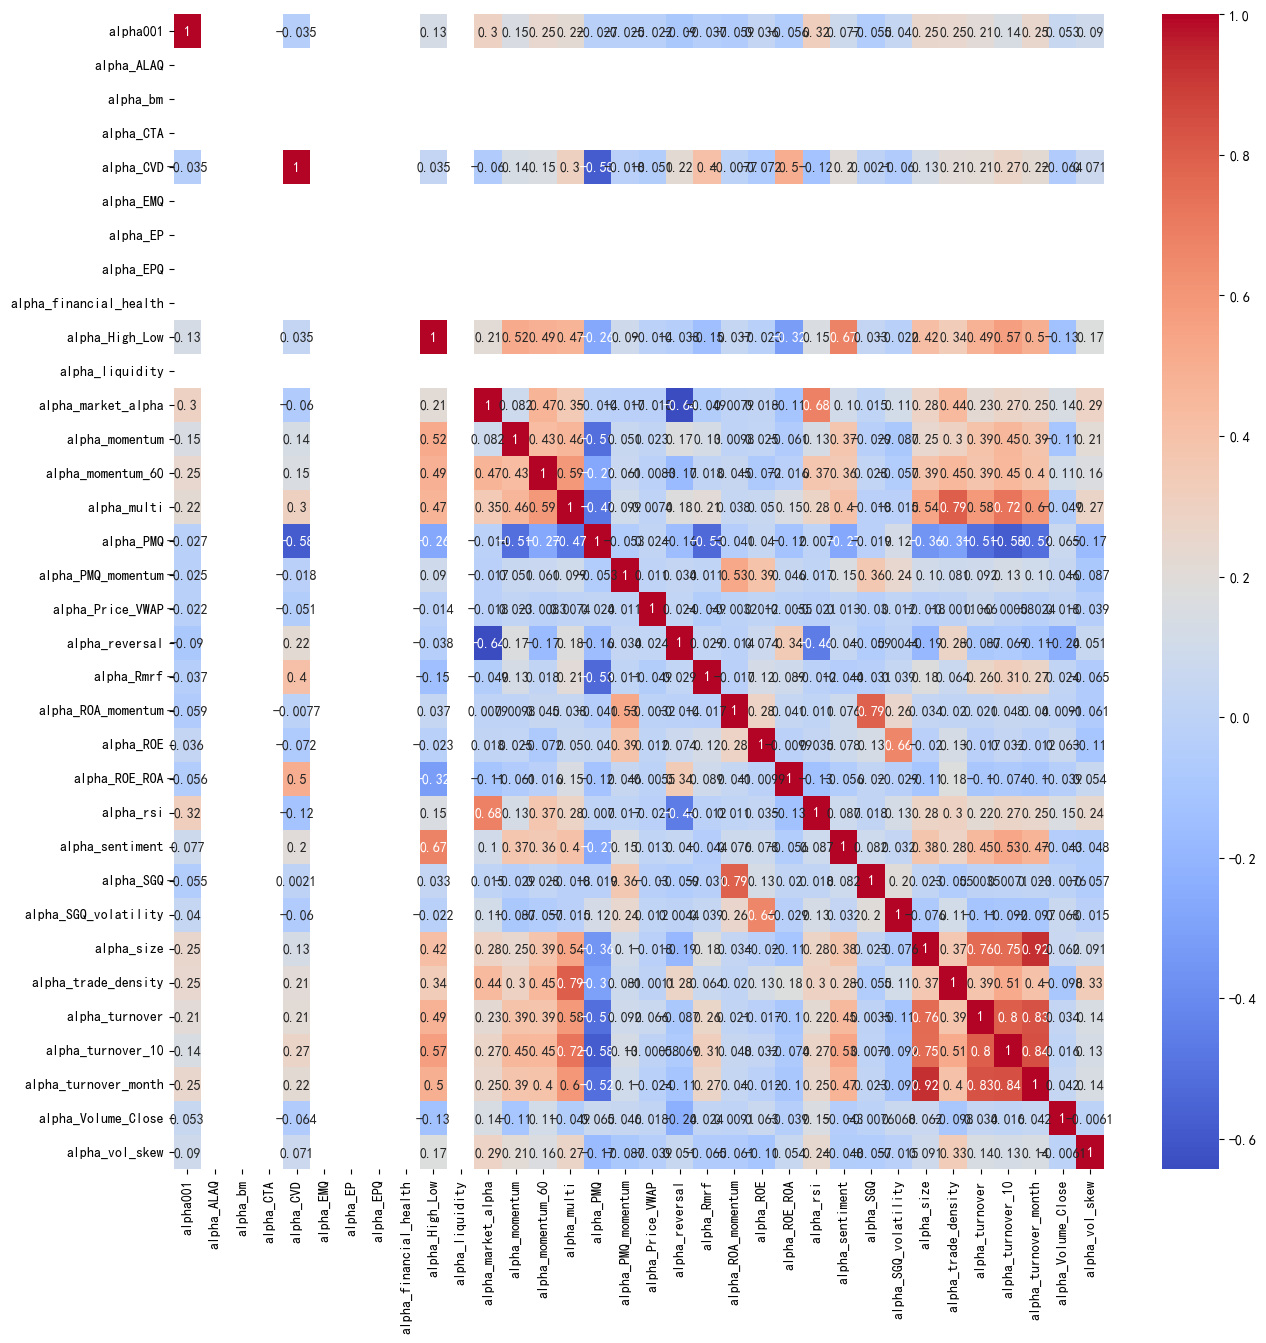

In [154]:
import seaborn as sns

# 计算相关矩阵
corr_matrix = x.corr()

# 绘制热图查看相关性
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

PCA

Explained variance ratio by each component: [2.53681399e-01 1.07771187e-01 9.96006068e-02 7.03067458e-02
 6.49384336e-02 5.31446006e-02 4.07374618e-02 3.84988289e-02
 3.75457470e-02 3.36250510e-02 3.27889794e-02 2.71380441e-02
 2.37019423e-02 1.82924924e-02 1.71202370e-02 1.38313648e-02
 1.24611614e-02 1.00746949e-02 8.64607633e-03 8.25554253e-03
 7.18977226e-03 6.62415611e-03 6.09678491e-03 4.31440134e-03
 2.10285034e-03 1.51143839e-03 3.12838157e-17 3.43389679e-18
 3.13703403e-18 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Principal components (eigenvectors):
[[ 1.18678911e-01  1.11022302e-16 -0.00000000e+00 ...  3.36130881e-01
   1.28227697e-03  1.06036742e-01]
 [-1.73431287e-01 -5.55111512e-17 -1.11022302e-16 ...  1.10195220e-02
  -1.76413814e-01 -3.65244584e-02]
 [-7.26514628e-02 -0.00000000e+00 -0.00000000e+00 ... -1.75433231e-02
   4.65711465e-03 -1.17605352e-01]
 ...
 [ 0.00000000e+00 -3.49704691e-02 -2.41563271e-01 ...  2.45450650e-15
   8.9686

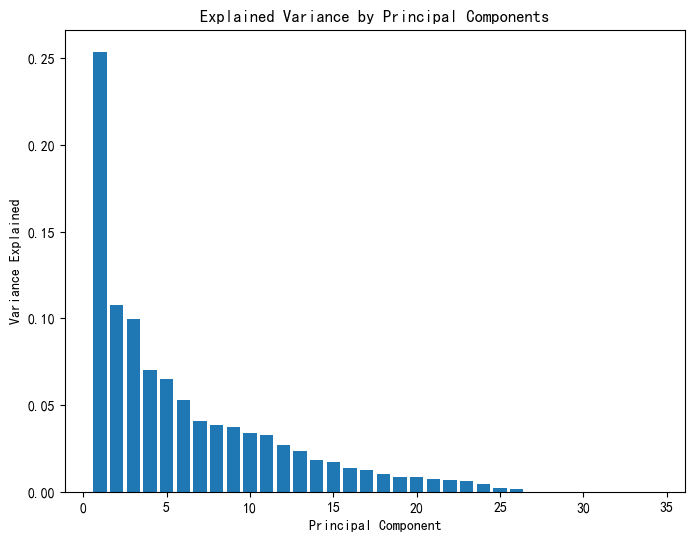

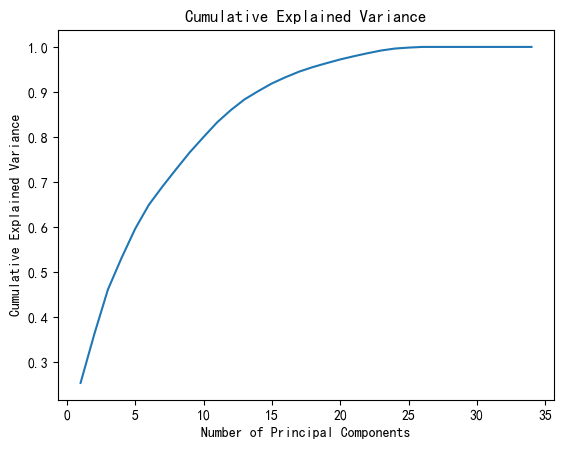

In [156]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 假设 X 是你的特征数据
# Step 1: 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)  # 对数据进行标准化

# Step 2: 执行 PCA
pca = PCA()  # 可以选择保留多少个主成分，默认会保留全部主成分
pca.fit(X_scaled)

# Step 3: 查看每个主成分的方差解释比例
explained_variance_ratio = pca.explained_variance_ratio_

# Step 4: 查看每个主成分的方差解释比例
print("Explained variance ratio by each component:", explained_variance_ratio)

# Step 5: 查看每个主成分的特征向量（系数）
print("Principal components (eigenvectors):")
print(pca.components_)

# Step 6: 转换数据到主成分空间
X_pca = pca.transform(X_scaled)

# Step 7: 绘制主成分的方差解释比例图
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.show()

# Step 8: 累积解释的方差比例（用于决定保留多少主成分）
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.show()

# Step 9: 如果你只想保留前 k 个主成分，可以使用:
pca = PCA(n_components=5)  # 例如保留前 5 个主成分
X_pca = pca.fit_transform(X_scaled)

使用WLS

In [147]:
# 权重（可以是方差的倒数等，这里假设是一个简单的权重）
weights = 1 / (y ** 2)  # 这里使用简单的权重作为示例，具体情况视实际需求而定

# 加入常数项
x_wls = sm.add_constant(x)

# 进行 WLS 回归
wls_model = sm.WLS(y, x_wls, weights=weights).fit()

# 打印结果
print(wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:                 601939   R-squared:                       0.540
Model:                            WLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     75.25
Date:                Tue, 03 Dec 2024   Prob (F-statistic):          1.56e-258
Time:                        18:32:11   Log-Likelihood:                -1272.5
No. Observations:                1693   AIC:                             2599.
Df Residuals:                    1666   BIC:                             2746.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
alpha001                   0

In [157]:
# PCA后

# 权重（可以是方差的倒数等，这里假设是一个简单的权重）
weights = 1 / (y ** 2)  # 这里使用简单的权重作为示例，具体情况视实际需求而定

# 加入常数项
x_wls_pca = sm.add_constant(X_pca)

# 进行 WLS 回归
wls_model_pca = sm.WLS(y, x_wls_pca, weights=weights).fit()

# 打印结果
print(wls_model_pca.summary())

                            WLS Regression Results                            
Dep. Variable:                 601939   R-squared:                       0.421
Model:                            WLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     245.6
Date:                Tue, 03 Dec 2024   Prob (F-statistic):          2.16e-197
Time:                        18:39:59   Log-Likelihood:                -1467.0
No. Observations:                1693   AIC:                             2946.
Df Residuals:                    1687   BIC:                             2979.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4044      0.014   -176.202      0.0

使用LASSO: 评价是系数逆天

In [150]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 分割数据集，通常 LASSO 需要进行交叉验证来选择最佳的正则化参数
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 初始化 Lasso 模型，选择合适的正则化参数 alpha
lasso_model = Lasso(alpha=0.1)  # alpha 控制正则化强度

# 训练 Lasso 模型
lasso_model.fit(x_train, y_train)

# 获取模型系数
print("Lasso coefficients:", lasso_model.coef_)

# 预测并计算 MSE
y_pred = lasso_model.predict(x_test)
mse_lasso = mean_squared_error(y_test, y_pred)
print(f'MSE for Lasso: {mse_lasso:.8f}')

Lasso coefficients: [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0. -0.  0.  0.
  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0. -0.  0.]
MSE for Lasso: 0.79826378


In [158]:
# 使用PCA后

# 分割数据集，通常 LASSO 需要进行交叉验证来选择最佳的正则化参数
x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# 初始化 Lasso 模型，选择合适的正则化参数 alpha
lasso_model = Lasso(alpha=0.1)  # alpha 控制正则化强度

# 训练 Lasso 模型
lasso_model.fit(x_train, y_train)

# 获取模型系数
print("Lasso coefficients:", lasso_model.coef_)

# 预测并计算 MSE
y_pred = lasso_model.predict(x_test)
mse_lasso = mean_squared_error(y_test, y_pred)
print(f'MSE for Lasso: {mse_lasso:.8f}')

Lasso coefficients: [0.06834981 0.09151617 0.         0.13297253 0.06998075]
MSE for Lasso: 0.60229373


使用Ridge

In [151]:
from sklearn.linear_model import Ridge

# 分割数据集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 初始化 Ridge 模型，选择合适的正则化参数 alpha
ridge_model = Ridge(alpha=1.0)  # alpha 控制正则化强度

# 训练 Ridge 模型
ridge_model.fit(x_train, y_train)

# 获取模型系数
print("Ridge coefficients:", ridge_model.coef_)

# 预测并计算 MSE
y_pred = ridge_model.predict(x_test)
mse_ridge = mean_squared_error(y_test, y_pred)
print(f'MSE for Ridge: {mse_ridge}')

Ridge coefficients: [ 0.02770674  0.          0.          0.          0.13263195  0.
  0.          0.          0.         -1.61985297  0.         -0.40031546
  0.22689907 -0.11871891  1.01895246 -2.75204957  0.10901538  0.04550257
 -0.52544377  0.01280383 -0.33507447  0.10138635  1.63043427  0.14808088
 -0.69250864  0.22851137 -0.32928868 -1.16423715  0.79716937  0.0570241
  0.33490291  0.69515694 -0.25334615 -0.14297566]
MSE for Ridge: 0.5542630590201949


In [159]:
# PCA后

# 分割数据集
x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# 初始化 Ridge 模型，选择合适的正则化参数 alpha
ridge_model = Ridge(alpha=1.0)  # alpha 控制正则化强度

# 训练 Ridge 模型
ridge_model.fit(x_train, y_train)

# 获取模型系数
print("Ridge coefficients:", ridge_model.coef_)

# 预测并计算 MSE
y_pred = ridge_model.predict(x_test)
mse_ridge = mean_squared_error(y_test, y_pred)
print(f'MSE for Ridge: {mse_ridge}')

Ridge coefficients: [0.08356185 0.12589114 0.008598   0.1850308  0.12748431]
MSE for Ridge: 0.581374591598764
